In [133]:
import os
import re
import imp
import sys

import numpy as np
import pandas as pd
import codecs
import nbimporter
import data_processing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from collections import Counter
from DataProcessing import getfile, get_data, get_record
from HelperFunctions import wordcloud_draw
from gensim.corpora import Dictionary
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import TopicAnalysis


from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# import helper_util as helper_util
# from helper_util import getfile

[nltk_data] Downloading package punkt to /Users/sdalton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sdalton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sdalton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
airport_codes = pd.read_csv('airport_codes.csv', header='infer', encoding='unicode-escape')

In [3]:
cities = airport_codes['city'].str.lower().tolist()
airport_code_list = airport_codes['airport_code'].tolist()

In [4]:
all_lines = []
getfile('./4U_Reviews.txt', all_lines)

['"they have been unresponsive"\n',
 'Brian McNamee (Canada) 16th October 2015\n',
 '2\n',
 'We flew with Germanwings (or tried to) on September 30th. After two lengthy delays passengers were notified that the flight was cancelled and to return to the check-in counter for further information. After waiting at the counter for another 30 minutes or so, staff began issuing refunds or providing alternate travel options to passengers. By this point it was quite late in the evening with limited options (plus we were 5+ hours after planned departure). We managed to get a voucher with 3 other passenger to get a flight from Stuttgart to Zurich with an ongoing connection to Amsterdam (flights were with Swiss). We made the flight and the connector (which was held back waiting for about 70 of us) however luggage did not make it. Short of this is the airline was ill-prepared to manage this. They offered little information or options to passengers. since returning home I have been attempting to cont

In [5]:
results = []
reviews_list = get_data(all_lines, results)

number of records: 127


In [6]:
all_reviews = [get_record(review, cities) for review in reviews_list]

In [7]:
all_reviews[25]

{'Cabin Flown': 'Economy',
 'Cabin Staff Service': '12345',
 'Food & Beverages': '12345',
 'Inflight Entertainment': '12345',
 'Recommended': 'yes',
 'Seat Comfort': '12345',
 'Value For Money': '12345',
 'customer_name': 'Robert Wolf ',
 'possible_route': 'dusseldorf london',
 'review_country': 'United Kingdom',
 'review_date': ' 22nd December 2014',
 'review_score': '7',
 'review_text': "Flew at the end of October from London via Dusseldorf to Vienna. Both flights were on time. However I upgraded myself to a Smart fare. The legroom is decent however I wish I would benefit at Boarding. No Priority Boarding anywhere. I understand you pay for the Extra Legroom however I still believe we should board before other Economy passengers. The food is horrible. I did not touch it. I don't recommend it. The seats were ok and the crew could be a bit friendlier. Overall I would consider it again however some improvements to be done.",
 'review_title': 'Germanwings customer review'}

In [145]:
data = pd.DataFrame(all_reviews)
data["review_year"] = data["review_date"].str[-4:].astype(int)
data["review_score"]= np.where(data["review_score"]=='na', -1, data["review_score"]).astype(int)
data["review_text_length"] = data["review_text"].str.count(' ').add(1)

data['possible_route2']=data['review_text'].str.findall("[A-Z]{3}-[A-Z]{3}-[A-Z]{3}|[A-Z]{3}-[A-Z]{3}").agg(lambda x: '-'.join(map(str, x))).astype('str')
data['route'] = np.where(data['Route'].fillna(data['possible_route'])=='',data['possible_route2'],data['Route'].fillna(data['possible_route']))
data['route'] = data['route'].str.replace('to','').str.replace('via', '').str.replace('-', ' ')
data['route_city1'] = data['route'].str.split(' ')
data['recommended'] = np.where(data.Recommended=='no', 0,1)
data['Type Of Traveller'] = data['Type Of Traveller'].fillna('Unknown')
data['review_text'] = data.review_text.str.lower()
data['review_text'] = data.review_text.str.replace('not be on time', 'delayed').str.replace('not on time', 'delayed').str.replace('on time', 'punctual').str.replace("'",'')

score_fields =['Cabin Staff Service','Food & Beverages', 'Ground Service', 'Inflight Entertainment',
       'Seat Comfort', 'Value For Money', 'Wifi & Connectivity']



for column in score_fields:
    new_name = 'scored_' + column.replace(' ', '').replace('&','')
    data[str(new_name)] = np.where(data[column]=='12345', 1, 0) 
    
data['total_scored_fields'] = data[[f for f in data.columns.values if 'scored_' in f]].sum(axis=1)    
data = data.drop(score_fields + ['Recommended','possible_route2', 'possible_route', 'Route'], axis=1)    

In [9]:
data['review_text'][0]

'we flew with germanwings (or tried to) on september 30th. after two lengthy delays passengers were notified that the flight was cancelled and to return to the check-in counter for further information. after waiting at the counter for another 30 minutes or so, staff began issuing refunds or providing alternate travel options to passengers. by this point it was quite late in the evening with limited options (plus we were 5+ hours after planned departure). we managed to get a voucher with 3 other passenger to get a flight from stuttgart to zurich with an ongoing connection to amsterdam (flights were with swiss). we made the flight and the connector (which was held back waiting for about 70 of us) however luggage did not make it. short of this is the airline was ill-prepared to manage this. they offered little information or options to passengers. since returning home i have been attempting to contact them via email and phone calls to discuss compensation per passenger rights brochure and

In [10]:
data.columns.values

array(['Aircraft', 'Cabin Flown', 'Date Flown', 'Type Of Traveller',
       'customer_name', 'review_country', 'review_date', 'review_score',
       'review_text', 'review_title', 'review_year', 'review_text_length',
       'route', 'route_city1', 'recommended', 'scored_CabinStaffService',
       'scored_FoodBeverages', 'scored_GroundService',
       'scored_InflightEntertainment', 'scored_SeatComfort',
       'scored_ValueForMoney', 'scored_WifiConnectivity',
       'total_scored_fields'], dtype=object)

0    65
1    62
Name: recommended, dtype: int64


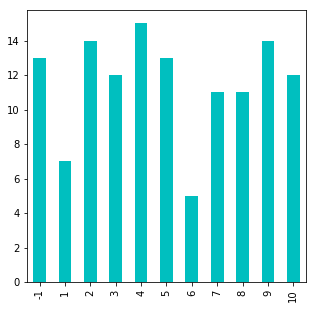

In [11]:
print(data.recommended.value_counts())

data.review_score.value_counts().sort_index().plot.bar(color='c', figsize=(5, 5))

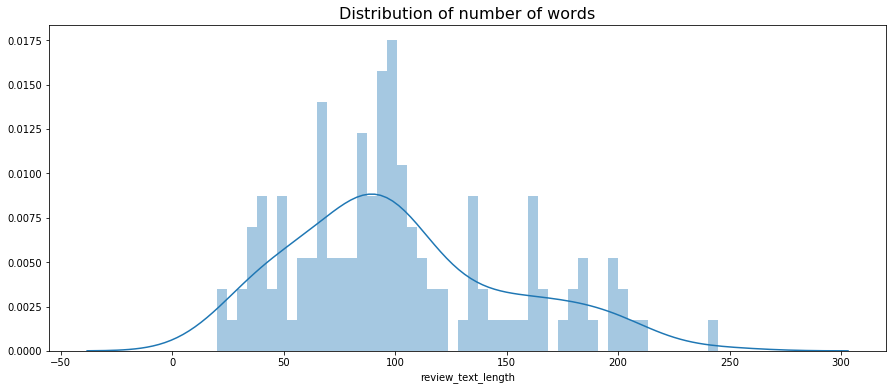

In [12]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(data['review_text_length'], bins=50, ax=ax);

In [13]:
data[['recommended','review_score','review_text_length', 'total_scored_fields', 'review_year']].corr(method='pearson')

,recommended,review_score,review_text_length,total_scored_fields,review_year
recommended,1.000000,0.839095,-0.277349,0.036520,0.052490
review_score,0.839095,1.000000,-0.352571,0.072197,0.077828
review_text_length,-0.277349,-0.352571,1.000000,0.102338,0.111464
total_scored_fields,0.036520,0.072197,0.102338,1.000000,0.871991
review_year,0.052490,0.077828,0.111464,0.871991,1.000000


In [14]:
data[data.review_year > 2008][['recommended','review_score','review_text_length', 'total_scored_fields', 'review_year']].corr(method='pearson')

,recommended,review_score,review_text_length,total_scored_fields,review_year
recommended,1.000000,0.838627,-0.276680,-0.041826,-0.064947
review_score,0.838627,1.000000,-0.359237,0.022760,0.005057
review_text_length,-0.276680,-0.359237,1.000000,0.126633,0.155261
total_scored_fields,-0.041826,0.022760,0.126633,1.000000,0.859991
review_year,-0.064947,0.005057,0.155261,0.859991,1.000000


In [15]:
#13 records are missing review score --filled with -1
data[data["review_score"]>0].groupby(['review_year']).agg(['mean', 'count'])
data[data["review_score"]>0].groupby(['Type Of Traveller']).agg(['mean', 'count'])

review_score       review_year       review_text_length  \
                          mean count        mean count               mean   
Type Of Traveller                                                           
Business                  3.80     5     2015.00     5              85.80   
Couple Leisure            2.60     5     2015.00     5             149.20   
FamilyLeisure             6.00     2     2015.00     2             115.00   
Solo Leisure              5.00     2     2015.00     2              75.00   
Unknown                   5.83   100     2012.21   100              95.58   

                        recommended       scored_CabinStaffService        \
                  count        mean count                     mean count   
Type Of Traveller                                                          
Business              5        0.20     5                     1.00     5   
Couple Leisure        5        0.00     5                     1.00     5   
FamilyLeisure         2        0.50     2                     1.00     2   
Solo Leisure          2        0.50     2                     1.00     2   
Unknown             100        0.59   100                     0.58   100   

                   ...  scored_InflightEntertainment       scored_SeatComfort  \
                   ...                          mean count               mean   
Type Of Traveller  ...                                                          
Business           ...                          0.40     5               1.00   
Couple Leisure     ...                          0.20     5               1.00   
FamilyLeisure      ...                          0.50     2               1.00   
Solo Leisure       ...                          0.50     2               1.00   
Unknown            ...                          0.26   100               0.58   

                        scored_ValueForMoney       scored_WifiConnectivity  \
                  count                 mean count                    mean   
Type Of Traveller                                                            
Business              5                 1.00     5                     0.2   
Couple Leisure        5                 1.00     5                     0.2   
FamilyLeisure         2                 1.00     2                     0.5   
Solo Leisure          2                 1.00     2                     0.5   
Unknown             100                 0.88   100                     0.0   

                        total_scored_fields        
                  count                mean count  
Type Of Traveller                                  
Business              5                5.60     5  
Couple Leisure        5                5.00     5  
FamilyLeisure         2                6.00     2  
Solo Leisure          2                5.50     2  
Unknown             100                2.76   100  

[5 rows x 24 columns]

In [16]:
data[data["review_score"]>0].groupby(['Type Of Traveller']).agg(['mean', 'count'])

review_score       review_year       review_text_length  \
                          mean count        mean count               mean   
Type Of Traveller                                                           
Business                  3.80     5     2015.00     5              85.80   
Couple Leisure            2.60     5     2015.00     5             149.20   
FamilyLeisure             6.00     2     2015.00     2             115.00   
Solo Leisure              5.00     2     2015.00     2              75.00   
Unknown                   5.83   100     2012.21   100              95.58   

                        recommended       scored_CabinStaffService        \
                  count        mean count                     mean count   
Type Of Traveller                                                          
Business              5        0.20     5                     1.00     5   
Couple Leisure        5        0.00     5                     1.00     5   
FamilyLeisure         2        0.50     2                     1.00     2   
Solo Leisure          2        0.50     2                     1.00     2   
Unknown             100        0.59   100                     0.58   100   

                   ...  scored_InflightEntertainment       scored_SeatComfort  \
                   ...                          mean count               mean   
Type Of Traveller  ...                                                          
Business           ...                          0.40     5               1.00   
Couple Leisure     ...                          0.20     5               1.00   
FamilyLeisure      ...                          0.50     2               1.00   
Solo Leisure       ...                          0.50     2               1.00   
Unknown            ...                          0.26   100               0.58   

                        scored_ValueForMoney       scored_WifiConnectivity  \
                  count                 mean count                    mean   
Type Of Traveller                                                            
Business              5                 1.00     5                     0.2   
Couple Leisure        5                 1.00     5                     0.2   
FamilyLeisure         2                 1.00     2                     0.5   
Solo Leisure          2                 1.00     2                     0.5   
Unknown             100                 0.88   100                     0.0   

                        total_scored_fields        
                  count                mean count  
Type Of Traveller                                  
Business              5                5.60     5  
Couple Leisure        5                5.00     5  
FamilyLeisure         2                6.00     2  
Solo Leisure          2                5.50     2  
Unknown             100                2.76   100  

[5 rows x 24 columns]

In [105]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    
    df['document_sentences'] = df.review_text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty list
    

def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.review_text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
    
def remove_stopwords(df, stopWords, dropList):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = stopWords + dropList
    # we'll add our own special word in here 'qwerty'
    #stopwords.append(dropList)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))
     
        
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
    
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)    
    
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]    
    
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS    

# keepList=['no', 'not','don','again','very', 'only', 'so', 'really', 'don', 'does', \
#           'doesn', 'against', 'all', 'always', 'cant', 'cannot', 'cry', 'less', 'more', 'most', 'least', 'much']
drop = ['germanwings', 'flight', 'flights', 'passengers', 'passenger', 'lufthansa', 'airline']
gensim_stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
nltk_stopwords = [item.replace("'",'') for item in nltk.corpus.stopwords.words('english')  ] 
    
w2v_preprocessing(data)     
lda_get_good_tokens(data)
remove_stopwords(data, gensim_stopwords, drop)
stem_words(data)

In [42]:
data['review_text'][110]

'on two occasions had a very unpleasant experience with germanwings. the first time they canceled the flight with reference to weather - however when i checked the website of the arrival airport everyone else was flying save for germanwings. they merely referred to the decision of their company. we had to return back to strasbourg and wait for two days for the next flight on which they were able to assign us. i had a small baby with me and the new flight they offered was not even a direct flight. on the second occasion the flight was delayed for more than three hours. however until the very last moment the passengers were lied to about the delay. any attempts to obtain information and to be provided with vouchers for food were left without response. the call center in germany tried to hide information about the delay saying that the flight was delayed for less than two hours. while the website of the airport already showed that the delay was over three hours. the companys representativ

In [23]:
tokenized_only_dict = Counter(np.concatenate(data.stopwords_removed.values))
tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [24]:
tokenized_only_df[tokenized_only_df['count'] >1][0:50]

,count
service,52
good,51
crew,49
return,47
time,42
cologne,42
staff,42
one,41
seats,40
late,37


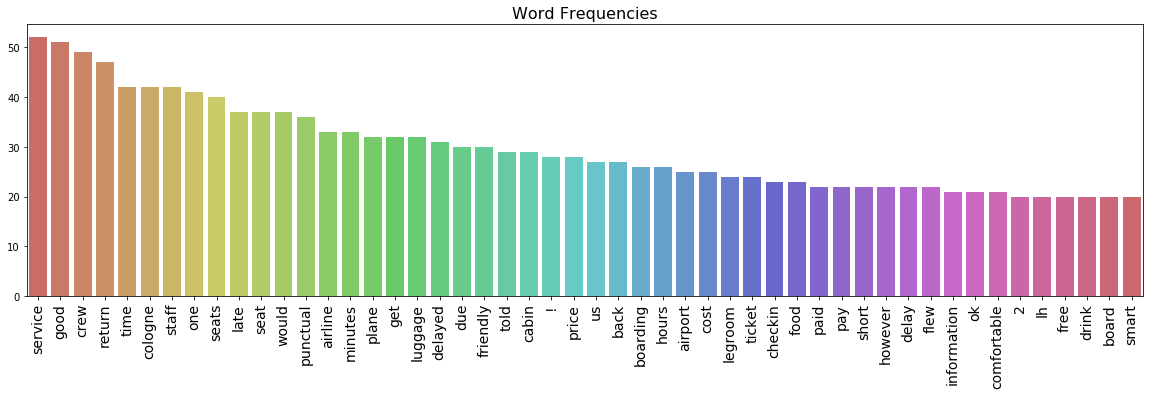

In [44]:
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);
    

In [56]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

dictionary.filter_extremes(no_above=0.95, no_below=2)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

document_to_bow(data)

cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

Found 1609 words.
Left with 704 words.


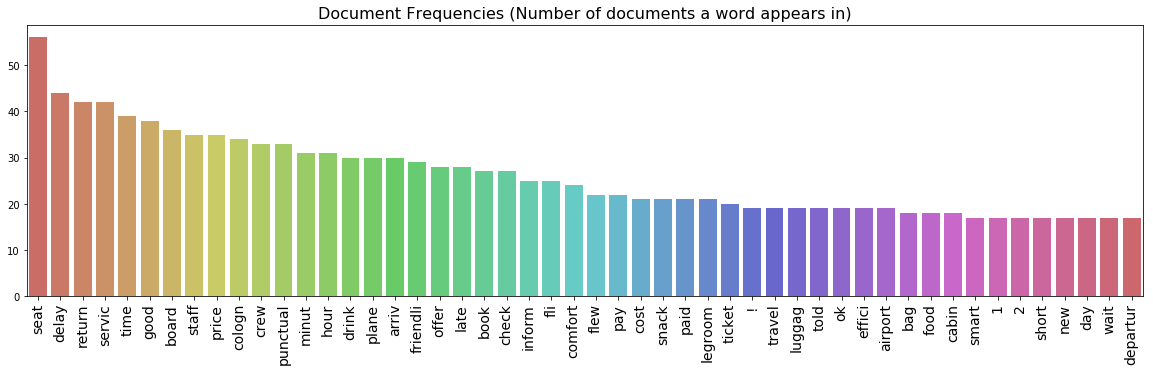

In [59]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);


In [68]:
no_words = list(np.concatenate(data.loc[data.recommended == 0, 'stemmed_text'].values))
yes_words = list(np.concatenate(data.loc[data.recommended == 1, 'stemmed_text'].values))

no_word_frequencies = {word: no_words.count(word) for word in cleansed_words_df.index[:50]}
yes_word_frequencies = {word: yes_words.count(word) for word in cleansed_words_df.index[:50]}

frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])
frequencies_df['no_freq'] = list(map(lambda word:
                                      no_word_frequencies[word],
                                      frequencies_df.index))
frequencies_df['yes_freq'] = list(map(lambda word:
                                          yes_word_frequencies[word],
                                          frequencies_df.index))

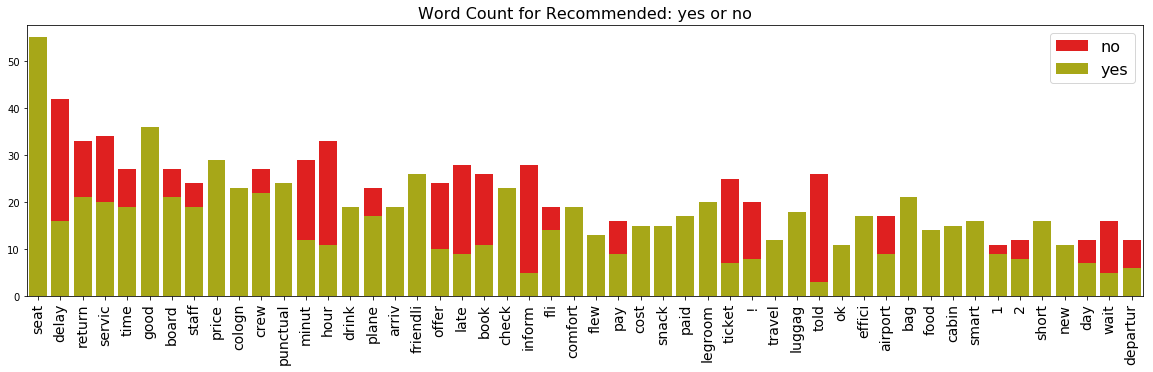

In [72]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['no_freq'].values, color='r', ax=ax, label="no")
sns.barplot(nrs, frequencies_df['yes_freq'].values, color='y', ax=ax, label="yes")

ax.set_title("Word Count for Recommended: yes or no", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

##People don't like to be told or informed or delayed or waiting!!

In [92]:
#LDA 

corpus = data.bow

num_topics = 50
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

In [93]:


data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

In [94]:
no_topic_distribution = data.loc[data.recommended == 0, 'lda_features'].mean()
yes_topic_distribution = data.loc[data.recommended == 1, 'lda_features'].mean()


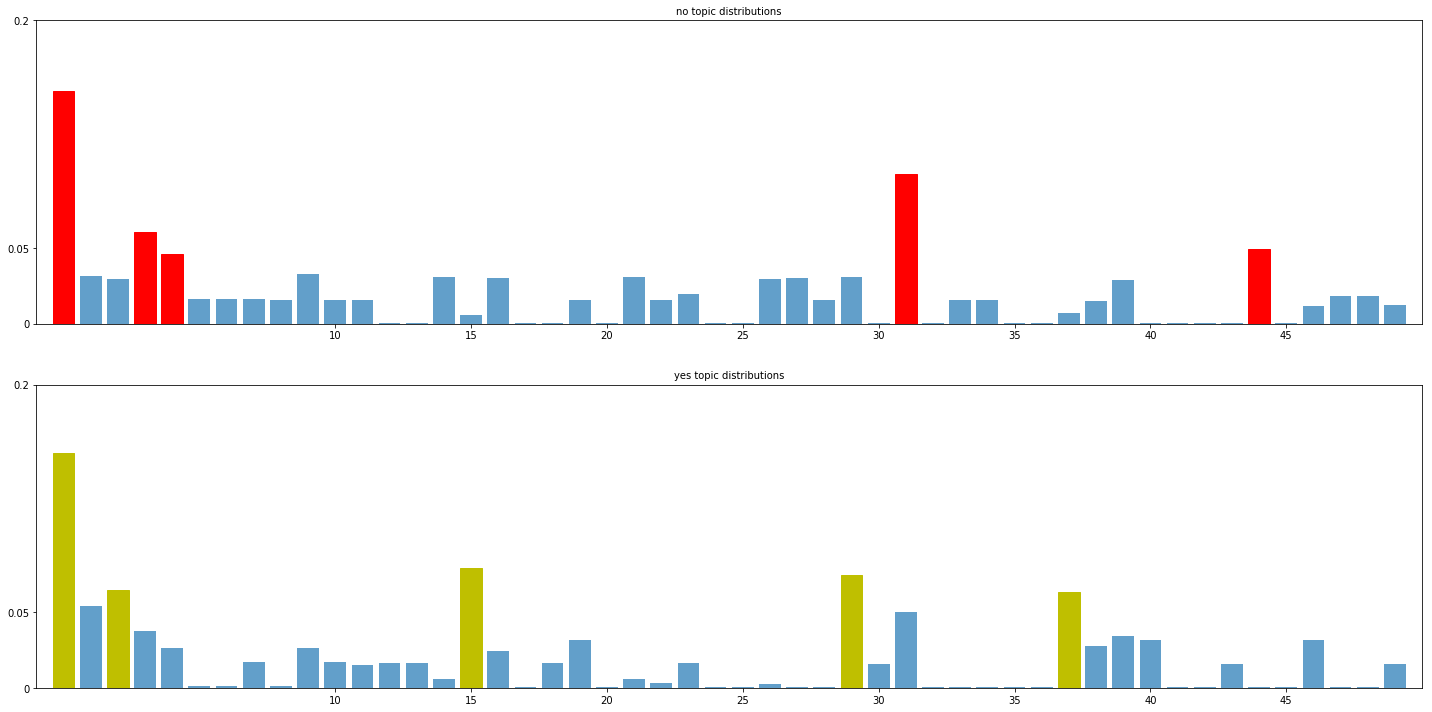

In [99]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("no topic distributions", fontsize=10)
ax2.set_title("yes topic distributions", fontsize=10)
# ax1.text(-10, 0.4, "Average Probability of Topic", fontsize=30, ha="center", va="center",
#          rotation="vertical")

for ax, distribution, color in zip([ax1,ax2],
                                   [no_topic_distribution,yes_topic_distribution],
                                   ['r','y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 50)
    ax.set_xticks(range(10,50,5))
    ax.set_xticklabels(range(10,50,5), fontsize=10)
    ax.set_ylim(0,0.2)
    ax.set_yticks([0,0.2,0.05])
    ax.set_yticklabels([0,0.2,0.05], fontsize=10)

fig.tight_layout(h_pad=3.)

In [103]:
for recommended, distribution in zip(['no', 'yes'], [no_topic_distribution, yes_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(recommended))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from no.
For topic 0, the top words are: crew, seat, good, drink, return.
For topic 3, the top words are: time, punctual, airport, definit, attend.
For topic 4, the top words are: servic, fli, seat, depart, lh.
For topic 31, the top words are: return, hour, seat, delay, told.
For topic 44, the top words are: time, possibl, minut, call, chang.

Looking up top words from top topics from yes.
For topic 0, the top words are: crew, seat, good, drink, return.
For topic 2, the top words are: seat, peopl, time, german, punctual.
For topic 15, the top words are: friendli, staff, sandwich, smart, time.
For topic 29, the top words are: seat, crew, short, effici, comfort.
For topic 37, the top words are: seat, good, check, arriv, food.



In [104]:
#word2vec

sentences = []
for sentence_group in data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))


Number of sentences: 900.
Number of texts: 127.


In [110]:
# Set values for various parameters
num_features = 100    # Word vector dimensionality
min_word_count = 2    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [111]:
data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.tokenized_sentences))

/Users/sdalton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [119]:
no_w2v_distribution = data.loc[data.recommended == 0, 'w2v_features'].mean()
yes_w2v_distribution = data.loc[data.recommended == 1, 'w2v_features'].mean()


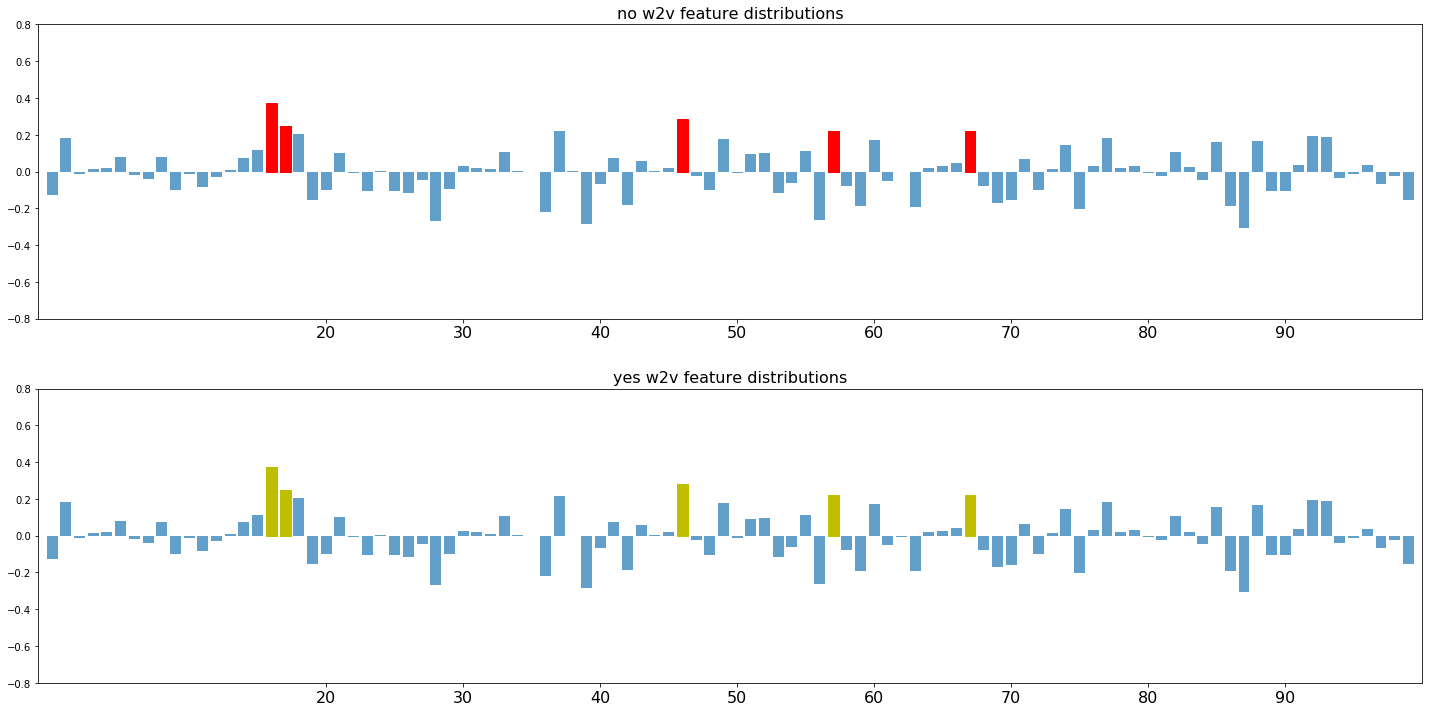

In [122]:
fig, [ax1,ax2] = plt.subplots(2,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("no w2v feature distributions", fontsize=16)
ax2.set_title("yes w2v feature distributions", fontsize=16)
#ax1.text(-10, 2.3, "Average feature vectors", fontsize=30, ha="center", va="center", rotation="vertical")

for ax, distribution, color in zip([ax1,ax2], [no_w2v_distribution,yes_w2v_distribution], ['r','y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, 100)
    ax.set_xticks(range(20,100,10))
    ax.set_xticklabels(range(20,100,10), fontsize=16)
    ax.set_ylim(-0.8,0.8)

fig.tight_layout(h_pad=3.)

In [126]:
label_encoder = LabelEncoder()

label_encoder.fit(data.recommended)
data['recommended'] = label_encoder.transform(data.recommended)

In [127]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [128]:
X_train_lda = np.array(list(map(np.array, data.lda_features)))
X_train_w2v = np.array(list(map(np.array, data.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)


In [134]:
models = dict()

# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, data.recommended)

models['best_lr_lda'] = best_lr_lda

# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, data.recommended)

models['best_lr_w2v'] = best_lr_w2v



Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default 

,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-0.697534,-0.656316,1,l1
1,-0.714778,-0.595188,2,l2


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/sdalton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default 

,mean_test_score,mean_train_score,rank_test_score,param_penalty
1,-0.692965,-0.692797,1,l2
0,-0.693167,-0.693049,2,l1


In [135]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))


Model best_lr_lda has a test score of: -0.6975
Model best_lr_w2v has a test score of: -0.6930


In [ ]:
#LDA 

In [142]:
data[data["recommended"]==1]['stopwords_removed'].

3      [good, berlintegel, london, heathrow, problems...
6      [easy, checkin, dsseldorf, punctual, seats, go...
11     [punctual, booked, smart, fare, gave, extra, l...
14     [4u7779, 4u7778, may16, 26, prghamprg, economy...
15     [dusgvadus, operated, eurowings, crj, 900, com...
16     [flew, best, class, hamburg, cologne, best, bu...
19     [flew, bologna, berlin, february, a319, punctu...
20     [dusprg, best, value, comes, short, haul, shor...
21     [13th, december, heathrow, t2, vienna, cologne...
23     [hop, berlin, txl, paris, cdg, early, saturday...
24     [lhrstrlhr, time, gw, impressed, price, good, ...
25     [flew, end, october, london, dusseldorf, vienn...
26     [regular, hambhx, operated, eurowings, bombard...
28     [went, manchester, cologne, 21st, october, ret...
30     [flew, london, heathrow, cologne, bonn, monday...
34     [flew, vienna, hamburg, return, doesnt, fly, a...
35     [flew, lhr, txl, 14714, complain, single, aspe...
36     [lowcost, carrier, cours

Positive words


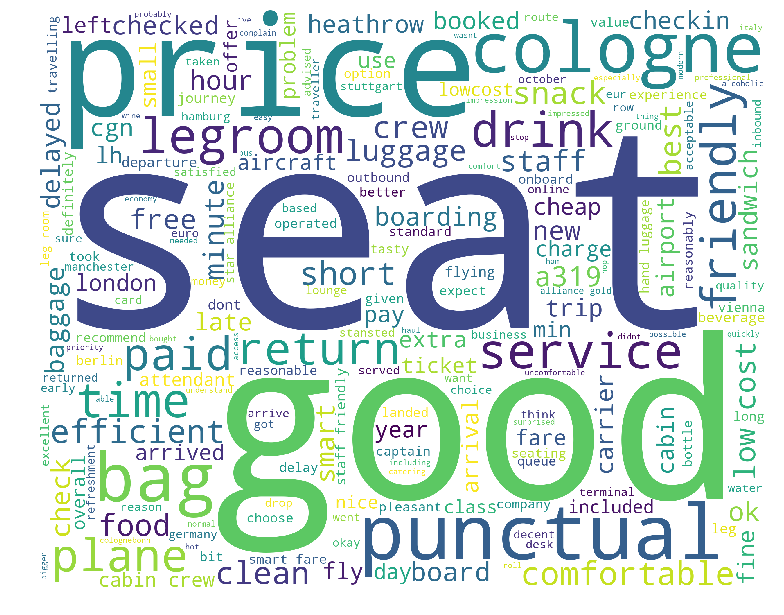

In [143]:
print("Positive words")
wordcloud_draw(data[data["recommended"]==1]['stopwords_removed'].agg(lambda x: ' '.join(map(str, x))).astype('str'),'white')

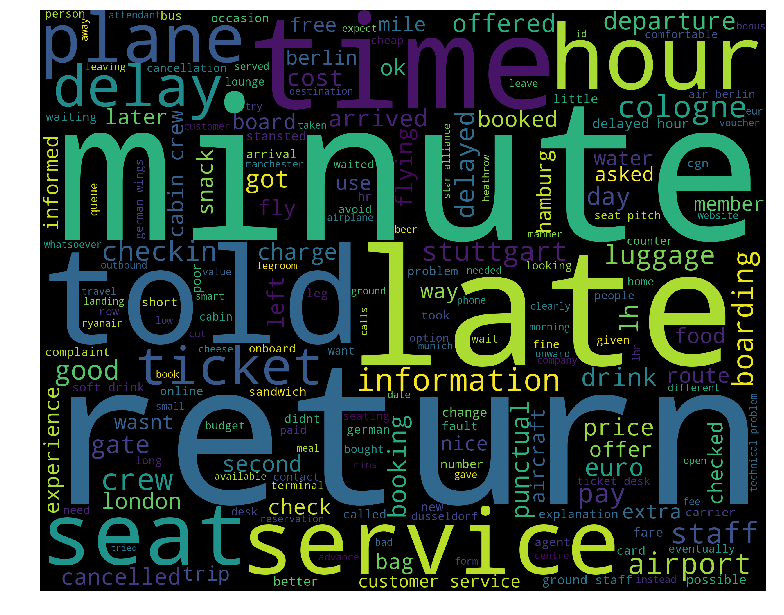

In [144]:
wordcloud_draw(data[data["recommended"]==0]['stopwords_removed'].agg(lambda x: ' '.join(map(str, x))).astype('str'))